In [1]:
!git clone https://github.com/sottorivalab/midaa.git
!pip install ./midaa
!pip install anndata scanpy matplotlib numpy


fatal: destination path 'midaa' already exists and is not an empty directory.
Processing ./midaa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for midaa: filename=midaa-0.1.0-py3-none-any.whl size=26331 sha256=ff369aa379a0cb611c72724088d07bdbef1a60a07f6e0d78afad7e1c0f576e26
  Stored in directory: /private/var/folders/z3/ljj1z3ln5gz7n4dw83jyw8900000gn/T/pip-ephem-wheel-cache-dhhxafm9/wheels/88/e8/3e/129c9ad0981caff8836c51a9591c603afebc698fcf01da7cda
Successfully built midaa
  Attempting uninstall: midaa
    Found existing installation: midaa 0.1.0
    Uninstalling midaa-0.1.0:
      Successfully uninstalled midaa-0.1.0


Dataset path: /Users/emmsi/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1/
Full dataset: (60000, 28, 28) (60000,)


ELBO: 699153.12500  : 100%|█████████████████| 1200/1200 [01:41<00:00, 11.82it/s]


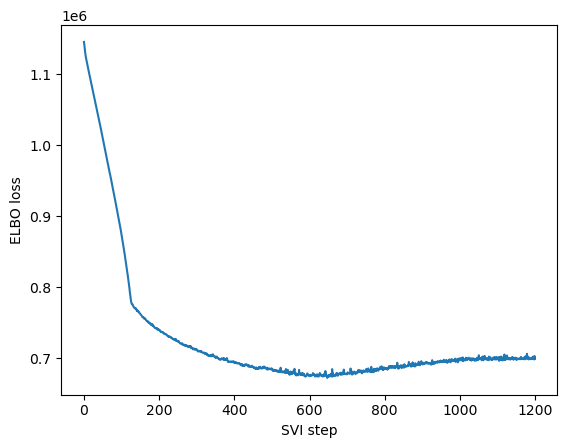

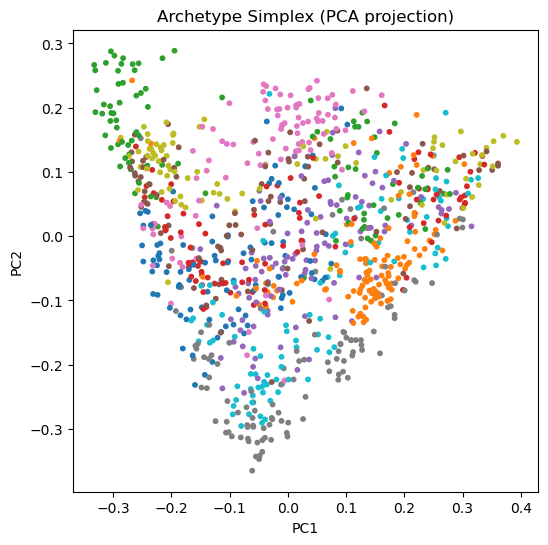

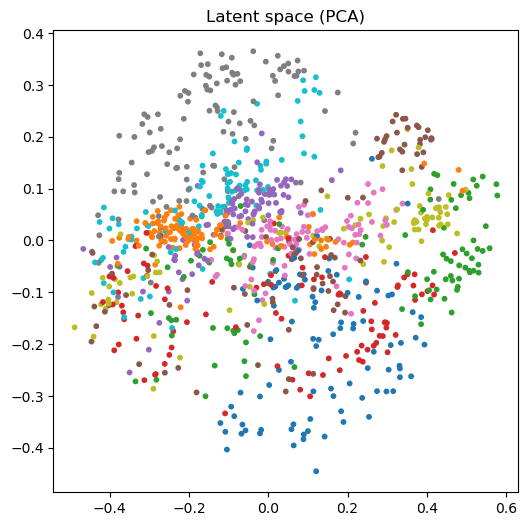

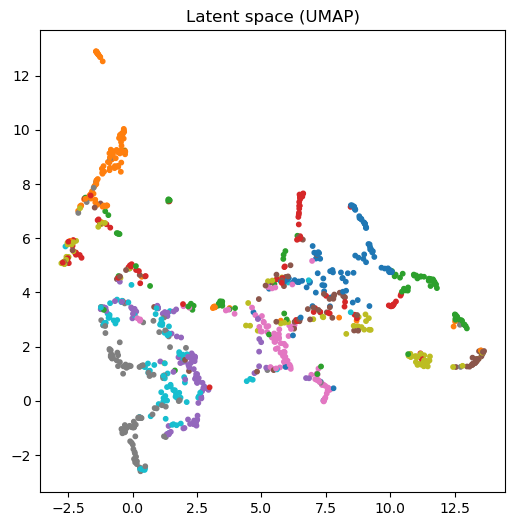

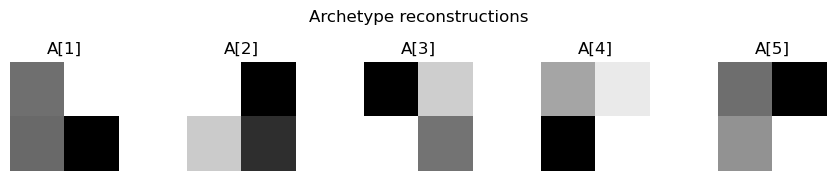

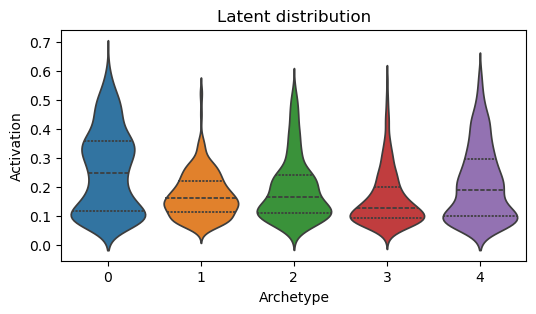

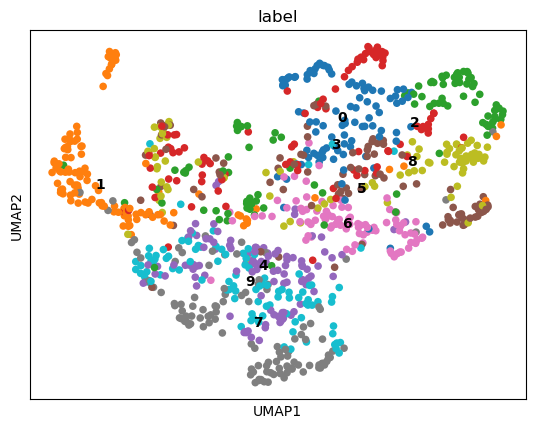

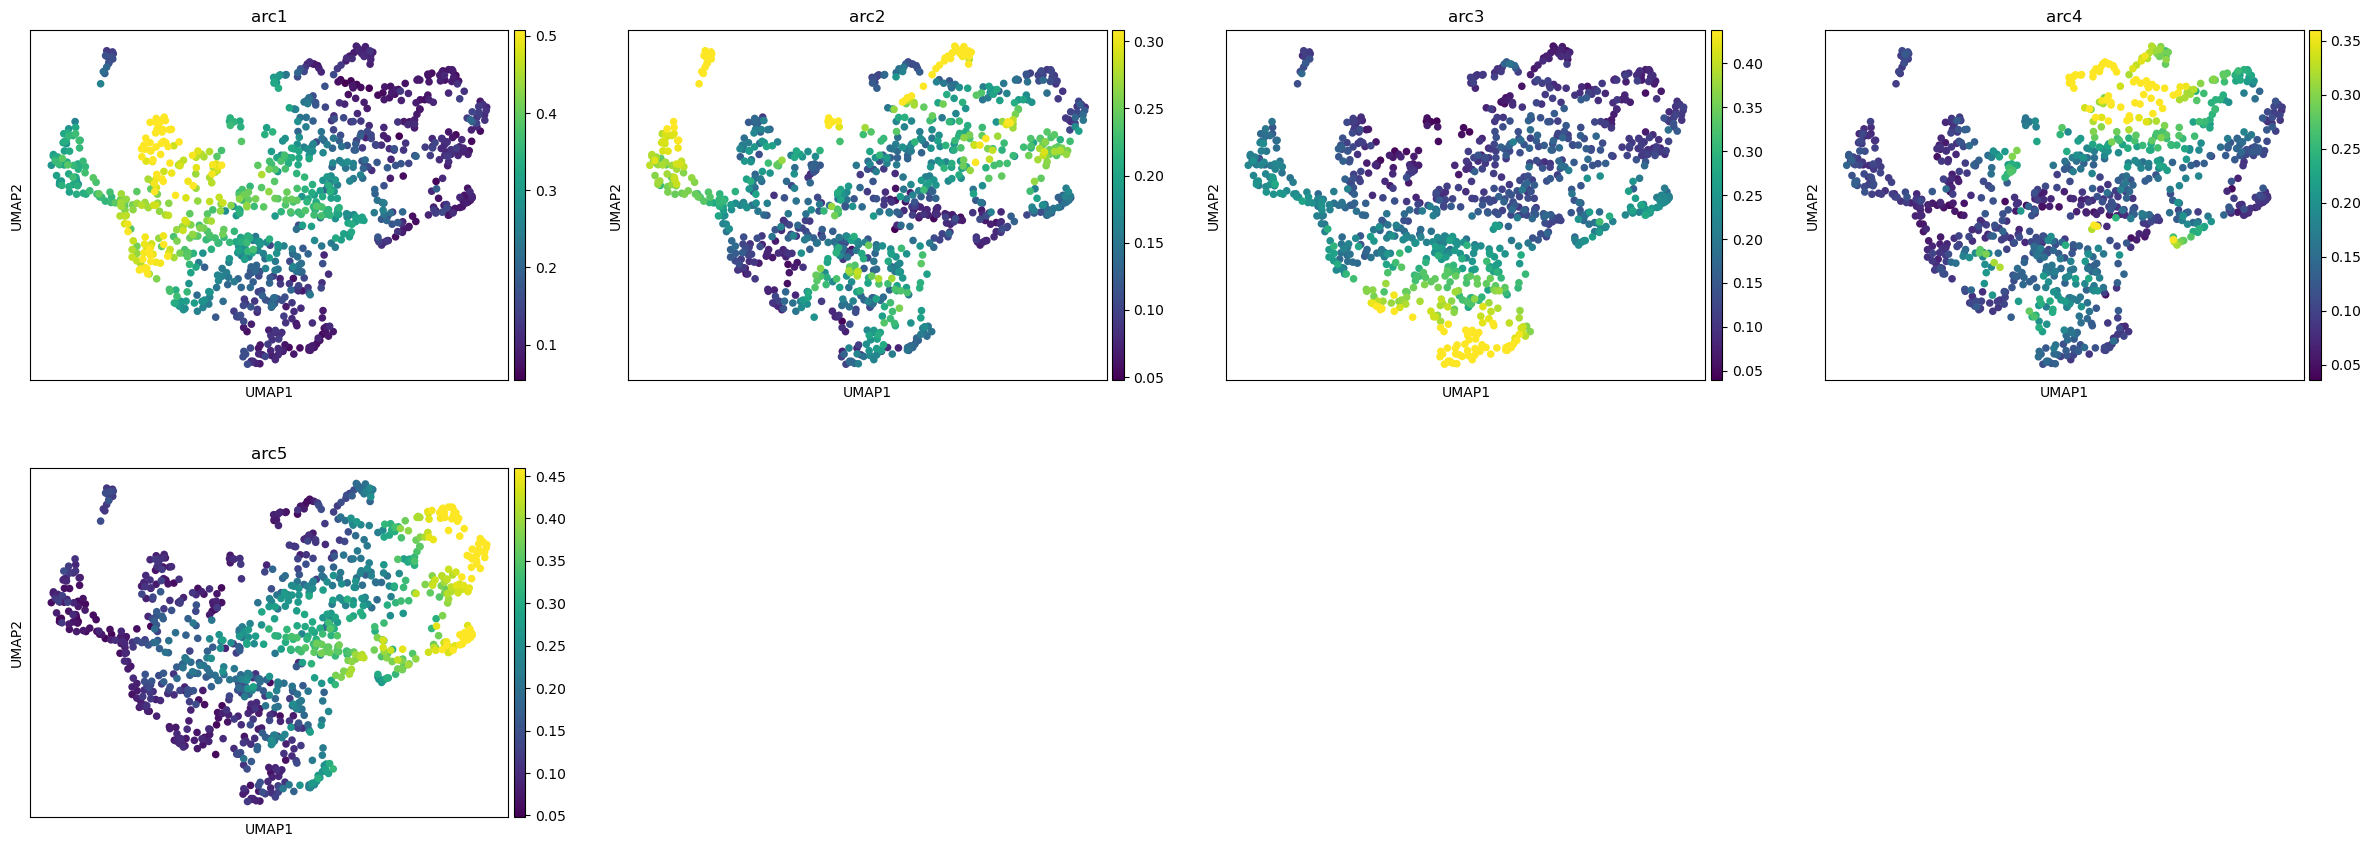

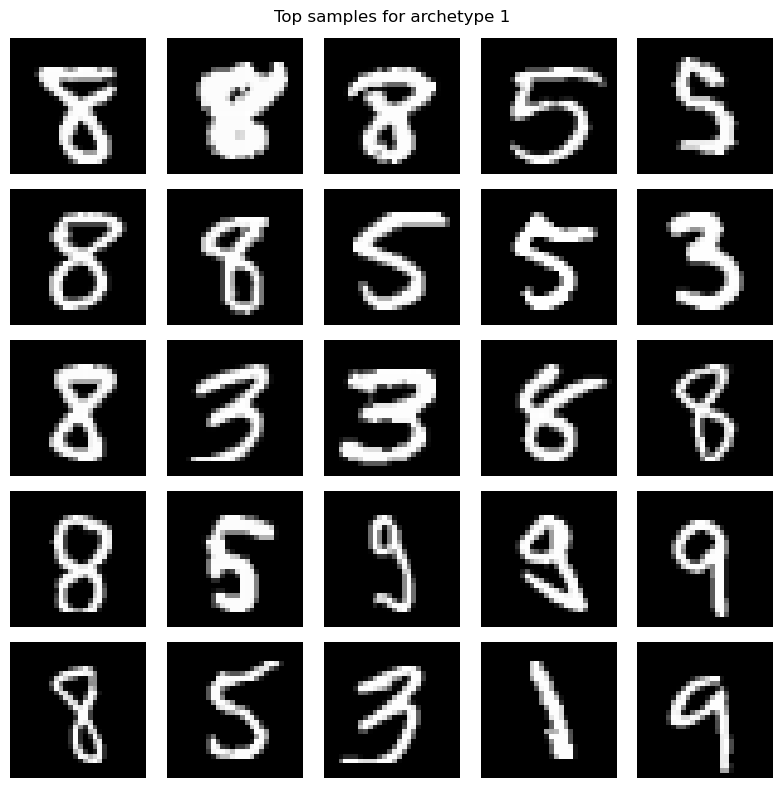

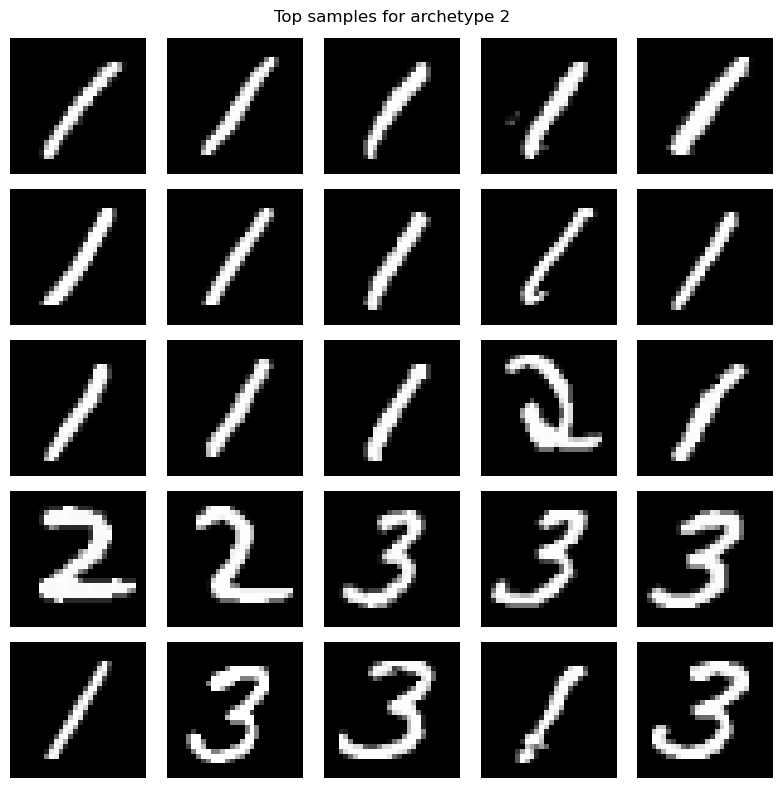

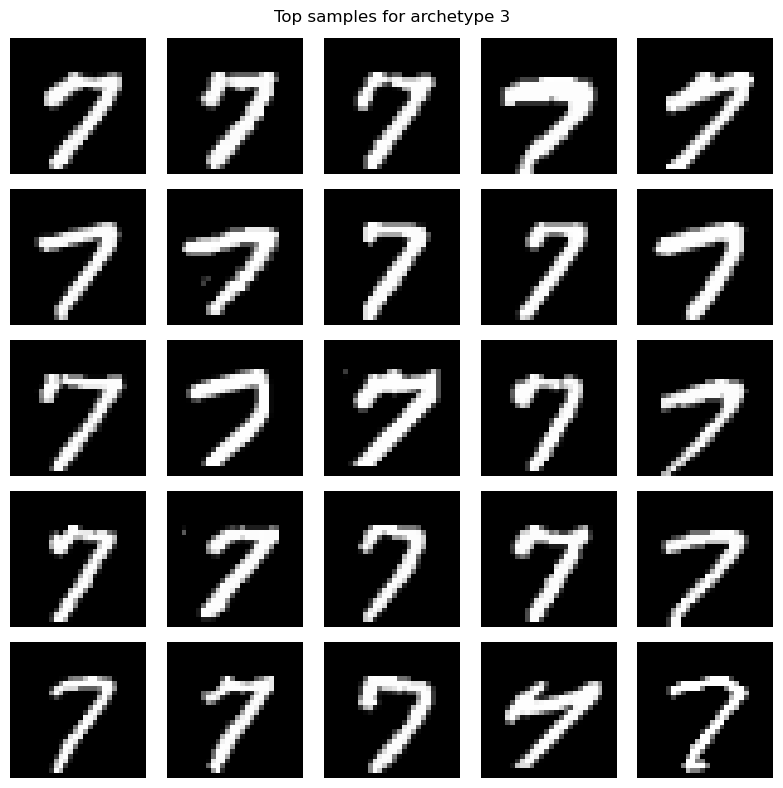

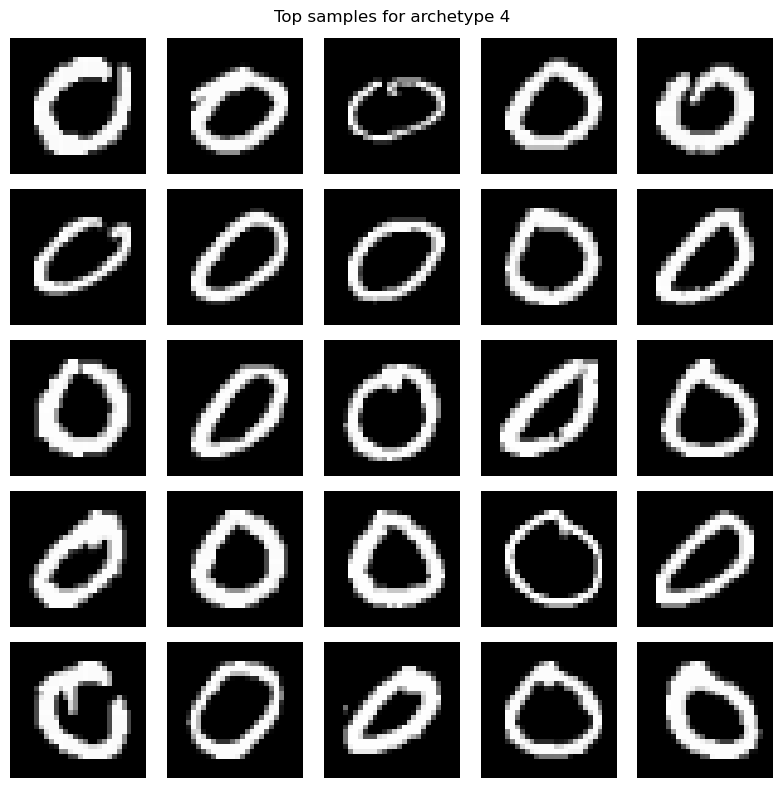

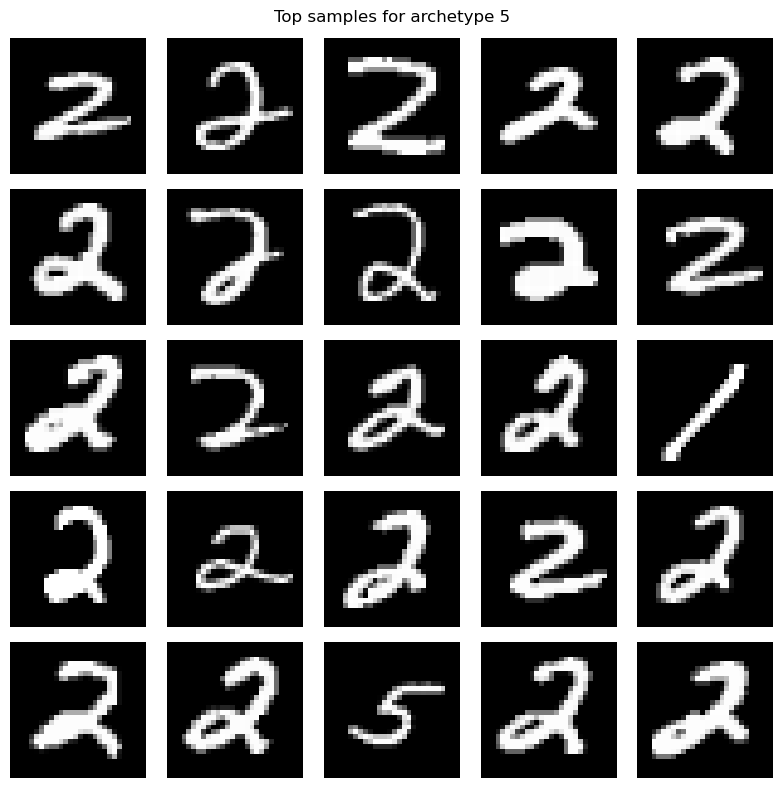

ELBO: 699153.12500  : 100%|█████████████████| 1200/1200 [01:40<00:00, 11.91it/s]


mSST: 51.589165
Archetype Consistency: 1.000000
Instability Index (ISI): 0.341120


In [13]:
# ==============================================================
# MIDAA on MNIST (Subset via KaggleHub)
# Correct ArchetypeConsistency & preprocess functions
# ==============================================================

# !pip install -U kagglehub
# !pip install midaa anndata scanpy seaborn matplotlib umap-learn scipy torch

import numpy as np
import struct, os, warnings, torch
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import midaa, kagglehub
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

warnings.filterwarnings("ignore")

# ==============================================================
# 1) Download + load MNIST
# ==============================================================
path = kagglehub.dataset_download("hojjatk/mnist-dataset") + "/"
print("Dataset path:", path)

def load_idx_images(filename):
    with open(filename, "rb") as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(num, rows, cols)

def load_idx_labels(filename):
    with open(filename, "rb") as f:
        _, num = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)

X = load_idx_images(os.path.join(path, "train-images-idx3-ubyte", "train-images-idx3-ubyte"))
y = load_idx_labels(os.path.join(path, "train-labels-idx1-ubyte", "train-labels-idx1-ubyte"))
print("Full dataset:", X.shape, y.shape)

# ==============================================================
# 2) Subset (for speed)
# ==============================================================
n = 1000  # du kan ændre dette (f.eks. 200, 1000, 2000)
X, y = X[:n], y[:n]
X_flat = X.reshape(n, -1).astype(np.float32) / 255.0

adata = ad.AnnData(X_flat)
adata.obs["label"] = y.astype(str)
adata.obsm["images"] = X

# ==============================================================
# 3) Prepare + Fit MIDAA
# ==============================================================
input_matrix, normalization_factor, input_types = midaa.get_input_params_adata(adata)
res = midaa.fit_MIDAA(
    input_matrix=input_matrix,
    normalization_factor=normalization_factor,
    input_types=input_types,
    narchetypes=5,
    steps=1200,
    batch_size=256,
    lr=0.003,
    CUDA=False
)

# ==============================================================
# Plot: ELBO
# ==============================================================
midaa.plot_ELBO(res)
plt.show()

# ==============================================================
# Plot: Archetype Simplex (PCA projection)
# ==============================================================
def plot_archetypes_simplex_fixed(res, labels, cmap="tab10"):
    A = res["inferred_quantities"]["A"]
    coords = PCA(2).fit_transform(A)
    plt.figure(figsize=(6,6))
    plt.scatter(coords[:,0], coords[:,1], c=labels.astype(int), s=10, cmap=cmap)
    plt.title("Archetype Simplex (PCA projection)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

plot_archetypes_simplex_fixed(res, adata.obs["label"].astype(int))

# ==============================================================
# Plot: Latent space (PCA) + UMAP
# ==============================================================
A = res["inferred_quantities"]["A"]
Z = A @ res["inferred_quantities"]["archetypes_inferred"]

# PCA
Z_pca = PCA(2).fit_transform(Z)
plt.figure(figsize=(6,6))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=adata.obs["label"].astype(int), s=10, cmap="tab10")
plt.title("Latent space (PCA)")
plt.show()

# UMAP
import umap
Z_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(Z)
plt.figure(figsize=(6,6))
plt.scatter(Z_umap[:,0], Z_umap[:,1], c=adata.obs["label"].astype(int), s=10, cmap="tab10")
plt.title("Latent space (UMAP)")
plt.show()

# ==============================================================
# Plot: Archetype reconstructions
# ==============================================================
def plot_archetypes_safe(res):
    iq = res["inferred_quantities"]
    decoded = iq.get("archetypes_inferred")
    if decoded is None:
        print("[WARN] archetypes_inferred missing; cannot plot.")
        return
    K, D = decoded.shape
    side = int(np.sqrt(D))
    plt.figure(figsize=(1.8*min(10,K), 1.8*((K+9)//10)))
    for i in range(K):
        ax = plt.subplot(((K+9)//10), min(10,K), i+1)
        try:
            plt.imshow(decoded[i].reshape(side, side), cmap="gray")
        except Exception:
            plt.imshow(decoded[i:i+1,:], cmap="gray", aspect="auto")
        ax.set_title(f"A[{i+1}]"); ax.axis("off")
    plt.suptitle("Archetype reconstructions")
    plt.tight_layout(); plt.show()

plot_archetypes_safe(res)

# ==============================================================
# Plot: Latent distribution
# ==============================================================
plt.figure(figsize=(6,3))
sns.violinplot(data=[A[:,k] for k in range(A.shape[1])], inner="quartile")
plt.xlabel("Archetype"); plt.ylabel("Activation"); plt.title("Latent distribution")
plt.show()

# ==============================================================
# Plot: UMAP by class + archetype activations
# ==============================================================
adata.obsm["X_aa"] = Z
sc.pp.neighbors(adata, use_rep="X_aa")
sc.tl.umap(adata)
sc.pl.umap(adata, color="label", legend_loc="on data")

for k in range(A.shape[1]):
    adata.obs[f"arc{k+1}"] = A[:, k]
sc.pl.umap(adata, color=[f"arc{k+1}" for k in range(A.shape[1])], vmax="p95")

# ==============================================================
# Plot: Top images per archetype
# ==============================================================
def show_top(k, top=25):
    scores = np.nan_to_num(A[:, k], nan=-np.inf)
    idx = np.argsort(-scores)[:min(top, len(scores))]
    imgs = adata.obsm["images"][idx]
    m = int(np.ceil(np.sqrt(len(imgs))))
    plt.figure(figsize=(1.6*m, 1.6*m))
    for i in range(len(imgs)):
        ax = plt.subplot(m, m, i+1)
        plt.imshow(imgs[i], cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Top samples for archetype {k+1}")
    plt.tight_layout(); plt.show()

for k in range(A.shape[1]):
    show_top(k)

# ==============================================================
# Functions: preprocess + ArchetypeConsistency
# ==============================================================
def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    i = []; j = []; v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / max(mSST, 1e-12)  # BESKYTTELSE mod mSST=0
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) +
                                            D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

# ==============================================================
# Run second MIDAA and compute metrics
# ==============================================================
np.random.seed(42)
torch.manual_seed(42)

res2 = midaa.fit_MIDAA(
    input_matrix=input_matrix,
    normalization_factor=normalization_factor,
    input_types=input_types,
    narchetypes=5,
    steps=1200,
    batch_size=256,
    lr=0.003,
    CUDA=False
)

# Beregn mSST ud fra RÅ data (ikke input_matrix)
_, mSST = preprocess(adata.X)

XC1 = res["inferred_quantities"]["archetypes_inferred"].T
XC2 = res2["inferred_quantities"]["archetypes_inferred"].T

consistency, ISI = ArchetypeConsistency(XC1, XC2, mSST)

print(f"\nmSST: {mSST:.6f}")
print(f"Archetype Consistency: {consistency:.6f}")
print(f"Instability Index (ISI): {ISI:.6f}")
